# Kindly note that this is for educational purpose only. 

## Notebook Objective:

In this notebook, we will take up the task of predicting crypto coin prices specifically bitcoin. The same can be applied for other coins as well.

We will try to predict the increase / decrease in the bitcoin price for the next day given the historical information. We will use the dataset from this [Kaggle Dataset - Cryptocoin Historical Prices - CoinGecko](https://www.kaggle.com/datasets/sudalairajkumar/cryptocurrency-historical-prices-coingecko?sort=published&select=bitcoin.csv) for our model building process. 

Please refer to this [blog post](https://web3ml.xyz/blogs/data-collection) to know more about the data collection process.

**Once again we would like to re-iterate that this is a sample notebook that has been created for educational purpose only. Please do not make any invetment decision based on this one.**  

Firstly, let us import the necessary modules.

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from scipy import stats

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

### Data Exploration

Let us read the bitcoin dataset and look at the top few rows

In [2]:
df = pd.read_csv("bitcoin.csv")
df.head()

,date,price,total_volume,market_cap,coin_name
0,2015-01-01 00:00:00.000,313.992,4.699936e+07,4.293958e+09,bitcoin
1,2015-01-02 00:00:00.000,314.446,3.885591e+07,4.301448e+09,bitcoin
2,2015-01-03 00:00:00.000,286.572,1.187789e+08,3.921358e+09,bitcoin
3,2015-01-04 00:00:00.000,260.936,2.055001e+08,3.571640e+09,bitcoin
4,2015-01-05 00:00:00.000,273.220,1.550381e+08,3.740880e+09,bitcoin


In [3]:
df.shape

(2835, 5)

We have 2835 rows in the dataset and data from 2015 at daily level. We have `price`, `volume` and `marketcap` information in the dataset apart from `date`. 

* `price` represents the price of bitcoin in USD on the given date
* `total_volume` represents the total volume traded in USD on the given date
* `market_cap` represents the market capitalization of bitcoin on the given date

<AxesSubplot:>

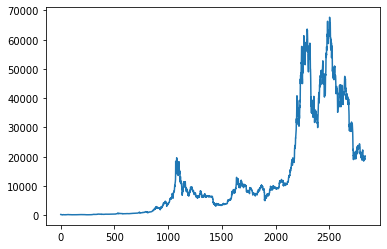

In [4]:
df["price"].plot()

As we could see from the price plot above, the price of the bitcoin ranges from ~250 USD to ~70,000 USD in the dataset. 

So if we try to predict the price directly, the model predictions may not be satisfactory due to this wide range.

Instead, let us try to predict the percentage of price change (Price on t+1 day / Price on t day) which will be range bound. 

### Feature Creation

Now let us create a function to create basic features for our model. Since we are trying to predict the percentage of price change, we will have percentage change features as our input features.

We will create percentage change features on `price` and `total_volume` for the previous 5 days for any given day. Instead of 5 days, we can also do 10 days or 15 days or any time frame. 

Also we can try a lot of other feature engineering here to improve our model predictions.

In [5]:
def create_features(df):
    features_to_use = []
    # We will create features based on last 5 days
    for day_value in range(5):
        # Price based features
        df[f"price_{day_value}day_previous"] = df["price"].shift(day_value)
        # Percent change of price
        df[f"price_change_{day_value}day"] = df["price"] / df[f"price_{day_value}day_previous"]
        features_to_use.append(f"price_change_{day_value}day")
        # Volume based features
        df[f"volume_{day_value}day_previous"] = df["total_volume"].shift(day_value)
        df[f"volume_change_{day_value}day"] = df["total_volume"] / df[f"volume_{day_value}day_previous"]
        features_to_use.append(f"volume_change_{day_value}day")     
    return df, features_to_use

### Target Creation

Now let us create a function to create the `target`. As discussed in the data exploration section, our target is the percentage change in the price prediction on the next day compared to current day.

`target = Price on 't+1' day / Price on 't' day`

In [6]:
def create_target(df):
    df["price_next_day"] = df["price"].shift(-1)
    df["target"] = df["price_next_day"] / df["price"]
    # We will remove the rows where the target is null
    df = df[~df["target"].isnull()].reset_index(drop=True)
    return df

### Validation Split

Now let us create a function to help us split the data into `train`, `validation` and `test` sets.

Since we have a time component in our dataset, let us split this based on time. We will use the last 30 days as our test dataset and the 30 days before that as our validation dataset. Please feel free to modify this time frame and try out.

In [7]:
def get_validation_test_split(df, features_to_use, val_days=30, test_days=30):
    X = df[features_to_use]
    y = df["target"].values
    test_index = - test_days
    val_index = test_index - val_days
    dev_X, val_X, test_X = X.iloc[:val_index,:], X.iloc[val_index:test_index,:], X.iloc[test_index:,:]
    dev_y, val_y, test_y = y[:val_index], y[val_index:test_index], y[test_index:]
    return dev_X, dev_y, val_X, val_y, test_X, test_y

Now let us call these above functions to create our data and features.

In [8]:
# feature creation
df, features_to_use = create_features(df)

# target_creation
df = create_target(df)

# data split
train_X, train_y, val_X, val_y, test_X, test_y = get_validation_test_split(df, features_to_use)
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)

(2774, 10) (2774,) (30, 10) (30,) (30, 10) (30,)


<AxesSubplot:>

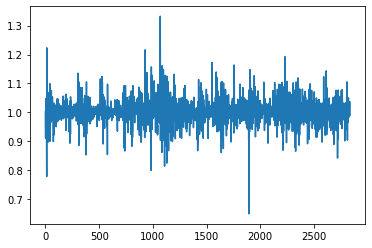

In [9]:
df["target"].plot()

As we can see, now our target is more rangebound compared to using `price` as target. 

But still we can see some huge fluctuations on certain days like 1.3 and 0.7 !!

### Handling Missing Values

We have some missing values in our input features since we created history based features. So we will backfill the missing values whenever they are present.

In [10]:
train_X = train_X.fillna(method="bfill")
val_X = val_X.fillna(method="bfill")
test_X = test_X.fillna(method="bfill")

### Model Building

Now let us build our models finally. We will build a linear regression model using our train dataset.

In [11]:
model = LinearRegression()
model.fit(train_X, train_y)

LinearRegression()

Now let us make predictions on the validation dataset and check the performance using spearman correlation. 

In [12]:
pred_val_y = model.predict(val_X)
stats.spearmanr(val_y, pred_val_y).correlation

0.26807563959955505

Not very bad as the spearman correlation is positive for our validation dataset. 

Now, let us check the confusion matrix of our validation predictions by converting the predictions to binary values - equivalent to converting our target to `long` or `short`

We will need a cutoff for making the predictions to binary. Let us use the median prediction value as our model cutoff to create binary predictions.

In [13]:
pred_train_y = model.predict(train_X)
model_cutoff = np.median(pred_train_y)
model_cutoff

1.0023511840477881

### Performance Evaluation

Now let us create a confusion matrix on the validation sample using the model cutoff. If the prediction value is more than the `model_cutoff`, then the `binary prediction value` is 1 or else 0.

We will also convert our target to `binary target value` (1 or 0) using a cutoff of 1.

From the domain perspective, 
* `binary target value` of 1 means bitcoin gave positive returns on the given day
* `binary target value` of 0 means bitcoin gave negative returns on the given day
* `binary prediction value` of 1 means the model predicted positive returns on the given day
* `binary prediction value` of 0 means the model predcited negative returns on the given day

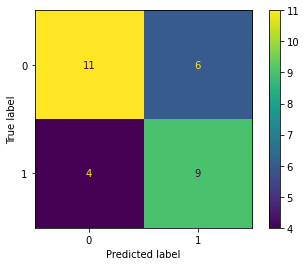

In [14]:
binary_target_value_val = val_y>1
binary_prediction_value_val = pred_val_y>model_cutoff
cm = confusion_matrix(binary_target_value_val, binary_prediction_value_val)
cm_display = ConfusionMatrixDisplay(cm).plot()

This looks good. Out of 30 days, the model has made correct predictions on 20 days (11 + 9). 

Let us also check the performance on our test set.

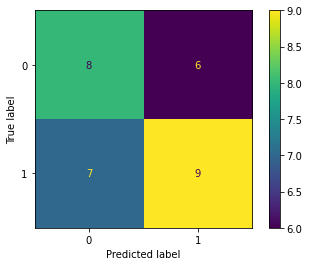

In [15]:
pred_test_y = model.predict(test_X)
binary_target_value_test = test_y>1
binary_prediction_value_test = pred_test_y>model_cutoff
cm = confusion_matrix(binary_target_value_test, binary_prediction_value_test)
cm_display = ConfusionMatrixDisplay(cm).plot()

On the test set, the model has made correct predictions for 17 days out of 30 days which is lower than the validation dataset. So this means that the model is volatile and not very stable.

### Profit / Loss Estimation

Now let us assume that we used the model to go `long` or `short` on bitcoin based on the model prediction and compute the profit and loss estimation.

When the model prediction is above cutoff, the action is `long` on the given day and when it is less than or equal to cutoff the action is `short` for the given day.

In [16]:
pred_val_df = pd.DataFrame({
    "actual": val_y,
    "preds": pred_val_y,
    "daily_change": val_y - 1,
    "long_short": np.where(pred_val_y > model_cutoff,1,-1),
})
pred_val_df["profit_loss"] = pred_val_df["daily_change"] * pred_val_df["long_short"]
pred_val_df

,actual,preds,daily_change,long_short,profit_loss
0,1.009268,1.002803,0.009268,1,0.009268
1,1.026989,1.002847,0.026989,1,0.026989
2,0.973976,1.000715,-0.026024,-1,0.026024
3,1.032113,1.002245,0.032113,-1,-0.032113
4,0.999997,1.002323,-0.000003,-1,0.000003
5,1.019317,1.002486,0.019317,1,0.019317
6,1.000912,1.002801,0.000912,1,0.000912
7,0.995043,1.002958,-0.004957,1,-0.004957
8,0.994508,1.003006,-0.005492,1,-0.005492
9,0.989012,1.001962,-0.010988,-1,0.010988


In the above table, we have the results for the 30 days on the validation sample.

* `daily_change` shows the percentage change of bitcoin price on the given day
* `long_short` shows the action on the given day. 1 is long and -1 is short.
* `profit_loss` shows the profit or loss in percentage on the given day

Now let us check the overall profit / loss for the 30 days on validation sample.

In [17]:
pred_val_df["profit_loss"].sum()

0.15313911193689533

Looks like the lady luck is on the model side during the validation sample duration!

Now let us check the profit / loss estimation for the test dataset days.

In [18]:
pred_test_df = pd.DataFrame({
    "actual": test_y,
    "preds": pred_test_y,
    "daily_change": test_y - 1,
    "long_short": np.where(pred_test_y > model_cutoff,1,-1),
})
pred_test_df["profit_loss"] = pred_test_df["daily_change"] * pred_test_df["long_short"]
pred_test_df

,actual,preds,daily_change,long_short,profit_loss
0,0.953187,1.002216,-0.046813,-1,0.046813
1,1.022330,1.002776,0.022330,1,0.022330
2,1.002186,1.001067,0.002186,-1,-0.002186
3,1.105410,1.001648,0.105410,-1,-0.105410
4,1.016283,1.000156,0.016283,-1,-0.016283
5,1.001493,1.002897,0.001493,1,0.001493
6,1.027593,1.005485,0.027593,1,0.027593
7,0.903548,1.002661,-0.096452,1,-0.096452
8,1.003515,1.004441,0.003515,1,0.003515
9,0.972662,1.002180,-0.027338,-1,0.027338


In the above table, we have the results for the 30 days on the test sample.

* `daily_change` shows the percentage change of bitcoin price on the given day
* `long_short` shows the action on the given day. 1 is long and -1 is short.
* `profit_loss` shows the profit or loss in percentage on the given day

Now let us check the overall profit / loss for the 30 days on the test sample.

In [19]:
pred_test_df["profit_loss"].sum()

0.006912561913379078

As we can see, the performance reduced to 0.6% for the test set duration from the 15% for the validation set duration. Both the validation and test set duration is 30 days each if we recall from our validation split.

**So this model is quite volatile and cannot be used as such!!**

But we have a baseline model and a good understanding of how to go about predicting the prices of tokens using ML. Building on top of this may result in a better model for us :D 

Some ideas that may help improve are:
* Trying out other features and see if that helps
* Trying out other models with hyperparameter optimization
* Validating the model on different time frames and see if the model holds good across time periods.
* Trying out on a different crypto coin